In [1]:
import ipywidgets
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio

plt.style.use('dark_background')
pio.templates.default = 'plotly_dark'

In [3]:
%load_ext autoreload
%autoreload 2
import gapminder
from gapminder.mock import LaserScan

Running in "mock" mode


In [4]:
N_SAMPLES = 1081

In [29]:
df = pd.read_csv(
    './lap.csv',
    header=None,
    names=[
    # "header",  #
    # "header.seq",  # 5
    # "header.stamp",  #
    "header.stamp.secs",  # 2829
    "header.stamp.nsecs",  #  69000000
    "header.frame_id",  # "laser_sensor_link"
    "angle_min",  # -1.57079994678
    "angle_max",  # 1.57079994678
    "angle_increment",  # 0.00436940183863
    "time_increment",  # 0.0
    "scan_time",  # 0.0
    "range_min",  # 0.10000000149
    "range_max",  # 30.0
    # float[] ranges
    *[f'ranges[{x:>03}]' for x in range(N_SAMPLES)],
    # 'etc',
    None,
    # float[] intensities
    ],
)
df

,header.stamp.secs,header.stamp.nsecs,header.frame_id,angle_min,angle_max,angle_increment,time_increment,scan_time,range_min,range_max,...,ranges[1072],ranges[1073],ranges[1074],ranges[1075],ranges[1076],ranges[1077],ranges[1078],ranges[1079],ranges[1080],NaN
0,1771905140,146290201,laser,-2.356194,2.356194,0.004363,0.000017,0.025,0.02,30.0,...,65.532997,65.532997,65.532997,65.532997,65.532997,65.532997,65.532997,65.532997,65.532997,NaN
1,1771905140,166292411,laser,-2.356194,2.356194,0.004363,0.000017,0.025,0.02,30.0,...,0.301000,0.310000,0.311000,0.300000,65.532997,65.532997,65.532997,65.532997,65.532997,NaN
2,1771905140,196353578,laser,-2.356194,2.356194,0.004363,0.000017,0.025,0.02,30.0,...,65.532997,0.304000,0.314000,0.319000,0.323000,0.322000,0.309000,65.532997,65.532997,NaN
3,1771905140,220689096,laser,-2.356194,2.356194,0.004363,0.000017,0.025,0.02,30.0,...,0.316000,0.331000,65.532997,65.532997,0.308000,0.334000,0.338000,0.344000,0.332000,NaN
4,1771905140,246412501,laser,-2.356194,2.356194,0.004363,0.000017,0.025,0.02,30.0,...,0.316000,0.329000,0.325000,0.325000,0.330000,0.326000,0.312000,65.532997,0.347000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662,1771905156,729931362,laser,-2.356194,2.356194,0.004363,0.000017,0.025,0.02,30.0,...,0.215000,0.220000,0.223000,0.219000,0.226000,0.247000,0.238000,0.258000,0.252000,NaN
663,1771905156,759959721,laser,-2.356194,2.356194,0.004363,0.000017,0.025,0.02,30.0,...,0.207000,0.206000,0.207000,0.208000,0.230000,0.230000,0.230000,0.234000,0.223000,NaN
664,1771905156,779985607,laser,-2.356194,2.356194,0.004363,0.000017,0.025,0.02,30.0,...,0.237000,0.236000,0.221000,0.221000,0.235000,0.242000,0.255000,0.251000,0.226000,NaN
665,1771905156,809980791,laser,-2.356194,2.356194,0.004363,0.000017,0.025,0.02,30.0,...,0.226000,0.226000,0.226000,65.532997,65.532997,65.532997,0.245000,0.240000,0.246000,NaN


In [30]:
msgs = [LaserScan(row) for _, row in df.iterrows()]

In [31]:
cmap = plt.get_cmap('inferno')
cmap.set_over('green')
cmap.set_under('red')

In [32]:
node = gapminder.GapMinder()

In [83]:
drive = np.array([node.get_drive_vector(msg) for msg in msgs])
drive

ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
o

array([[1.07486696, 0.50178216],
       [1.07831648, 0.54105207],
       [1.08272245, 0.51487213],
       ...,
       [3.94716497, 0.23125613],
       [3.96029579, 0.26616271],
       [3.92945644, 0.30543262]], shape=(667, 2))

In [74]:
drive_index = (df['angle_min'] - drive[:, 0]) / df['angle_increment']

In [77]:
%matplotlib widget

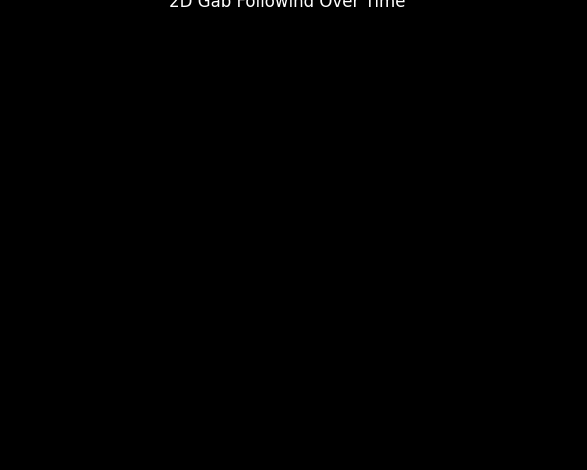

In [80]:
X = np.array(df.filter(like='ranges['))
X[(X < node.range_min) | (X > node.range_max)] = np.nan

fig, ax  = plt.subplots()  # figsize=np.array(X.shape) / 50)
ax.set(ylabel='Time (steps)', xlabel='Drive Angle (steps)', title='2D Gap Following Over Time')

im = ax.imshow(X, cmap=cmap, vmin=node.car_size, vmax=5, origin='lower')
fig.colorbar(im, ax=ax)

ax.scatter(y=range(len(drive_index)), x=drive_index, marker='.', c='#00000000', edgecolors='white')

fig.set_layout_engine('tight')
# fig.savefig('./resource/drive-strategy.png')
fig

In [ ]:
@ipywidgets.interact
def plot_obstruction_matrix(i: ipywidgets.IntSlider(0, 0, len(rs)) = 481):
    mat=finder.get_obstruction_matrix(rs[i])
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.set(
        xlabel='Obstruction Angle (steps)',
        ylabel='Obstructed Angles (steps)',
        title='Driveable Range Candidates by Angle',
    )
    im = ax.imshow(mat, cmap=cmap, vmin=0)
    fig.colorbar(im, label='Obstruction Range')
    return fig

In [ ]:
np.where(np.isnan(blocking), blocking.max(axis=1)[np.newaxis, :], blocking)

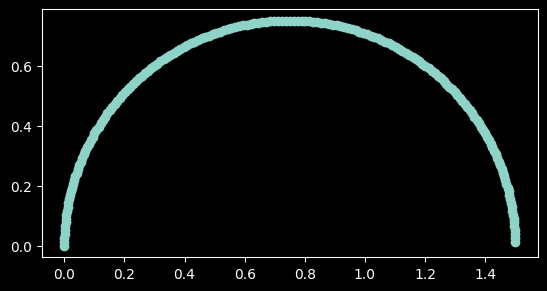

In [102]:
TURN_RADIUS = 0.75  # canot turn sharper than 1m radius
turn = np.radians(np.arange(180))
turn_x = TURN_RADIUS * (1- np.cos(turn))
turn_y = TURN_RADIUS * np.sin(turn)
fig, ax = plt.subplots()
ax.scatter(turn_x, turn_y)
ax.set(aspect='equal')
fig

In [103]:
turn_r = (turn_x**2 + turn_y**2)**0.5
turn_theta = np.arctan2(turn_x, turn_y)

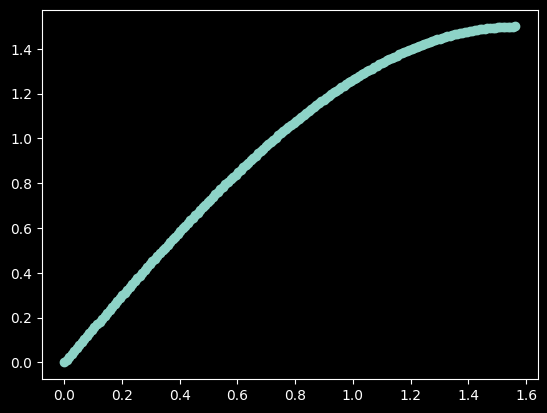

In [105]:
fig, ax = plt.subplots()
ax.scatter(y=turn_r, x=turn_theta)
fig

0, 0 (car) + 0, R (turn radius)